# Feature Selection
Generated features and labels from the cleaned data. The data should be ready to use to train an ML model.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.lines import Line2D
import joblib

from src.data.labels_util import load_labels, LabelCol, get_labels_file, load_clean_labels, get_workouts
from src.data.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, get_data_chunk,
    normalize_with_bounds, data_to_features, list_imu_abspaths, clean_imu_data
)
from src.data.util import find_nearest, find_nearest_index, shift, low_pass_filter, add_col
from src.data.workout import Activity, Workout
from src.data.data import DataState
from src.data.build_features import main as build_features
from src.data.features_util import list_test_files
from src.model.predict import group_points
from src.config import (
    TRAIN_POLE_DIR, TRAIN_BOOT_DIR, TRAIN_FEATURES_FILENAME, TRAIN_LABELS_FILENAME
)
from src.visualization.visualize import multiplot

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

## Generate Features
Create ML model's input dataset using the cleaned IMU data. Also create the labels to the input dataset. Separate these into training and testing datasets.

In [2]:
# build_features()

## Examine Feature and Label Integrity

<IPython.core.display.Javascript object>


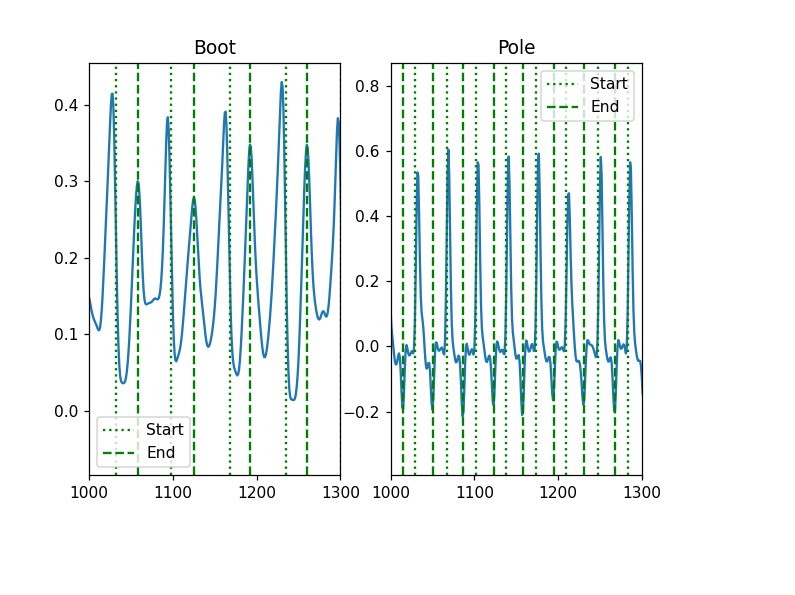

In [3]:
def plot_helper(idx, plot):
    def by_activity(activity: Activity):
        features_file, labels_file = list_test_files(activity)[1]
        features: ndarray = np.load(features_file)
        labels: ndarray = np.load(labels_file)
        
        # Plot x-axis acceleration
        plot.plot(features[:,0])

        # Plot labels
        steps: List[Tuple[int, int]] = group_points(labels)
        for start, end in steps:
            plot.axvline(x=start, color='green', linestyle='dotted')
            plot.axvline(x=end, color='green', linestyle='dashed')
                
        # Legend
        legend_items = [Line2D([], [], color='green', linestyle='dotted', label='Start'), 
                    Line2D([], [], color='green', linestyle='dashed', label='End')]
        plot.legend(handles=legend_items)
    
    if idx == 0:
        by_activity(Activity.Boot)
        plot.set_xlim([1000, 1300]) # Zoom (REMOVE to see the entire graph)
        plot.title.set_text('Boot')
    else:
        by_activity(Activity.Pole)
        plot.set_xlim([1000, 1300]) # Zoom (REMOVE to see the entire graph)
        plot.title.set_text('Pole')

multiplot(2, plot_helper)